# Data 100 Final Project

<b> Authors:</b> Ru Pei and Kevin Tang

For our Data 100 Final Project, we will be conducting analysis using the Basketball Dataset. 

## Motivating Question

<b> Is there a way to accurately predict whether a team will make the post-season based on historical data? </b> 

The subsequent analysis primarily aims to answer that question. We recognize that the most exiting moments of an NBA season typically occur in the postseason. Being able to accurately predict if a given team will advance or not has implications on a large variety of stakeholders (i.e. management, sports betters, players, etc). 

In answering that motivating question, we'll implicitly answer many more. These include:
- Empirically, what factors are most important in determining playoff qualification chances?
- To the casual fan, are the results largely intuitive, or are they somewhat surprising?
- Do in-game statistics (provided by the given data) paint the whole story? Are there other factors that are of importance? Are they easily quantifiable in models?
- How do these statistics show how the game has evolved in the past decade?

Let's set up the notebook and take a look at the provided data.

<b> NOTE: Please upgrade to the latest version of Pandas (1.0.3). If not, certain cells might not behave as intended. Moreover, installing lxml may be necessary if not already for web scraping purposes in the latter parts of the Notebook (`pip install lxml` or `pip3 install lxml`) </b>

In [1]:
# importing relevant libraries and frameworks
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re

# import necessary sklearn tools
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import accuracy_score
from sklearn import preprocessing 
from decimal import Decimal

# import plotly for cool visualizations
import plotly.offline as py
import plotly.express as px
import plotly.graph_objects as go

# ignoring warnings
warnings.filterwarnings('ignore')

/Users/kevin/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# tweaking preferences
pd.set_option('display.max_columns', None)
np.random.seed(100)

In [3]:
# importing data from given csv files
scores = pd.read_csv('2012-18_officialBoxScore.csv')
player_scores = pd.read_csv('2012-18_playerBoxScore.csv')
standings = pd.read_csv('2012-18_standings.csv')
team_scores = pd.read_csv('2012-18_teamBoxScore.csv')
college = pd.read_csv('college.csv')

### 1. Data Cleaning

We're going to clean the data given to us into a relevant tabular format (i.e. indexed by season and team), making it easier for us to explore the nuances of our question.

In [4]:
def dateToSeason(df, date_col, drop=True):
    """
    df: Pandas Dataframe
    date_col: String that references the column name of the date
    drop: Boolean to indicate if original date columns will be dropped
    
    return: An augmented Dataframe that converts dates into their respective NBA Season"""
    
    # define the range of dates that fall under each season
    season_range = {'2012/13': (df[date_col] >= '2012-10-30') & (df[date_col] <='2013-04-17'), \
          '2013/14': (df[date_col] >= '2013-10-29') & (df[date_col] <='2014-04-16'), \
          '2014/15': (df[date_col] >= '2014-10-28') & (df[date_col] <='2015-04-15'), \
          '2015/16': (df[date_col] >= '2015-10-27') & (df[date_col] <='2016-04-13'), \
          '2016/17': (df[date_col] >= '2016-10-25') & (df[date_col] <='2017-04-12'), \
          '2017/18': (df[date_col] >= '2017-10-17') & (df[date_col] <='2018-04-11')}

    # edit the Dataframe
    seasons_data = []
    for key in season_range.keys():
        curr = df.loc[season_range[key]]
        curr['season'] = [key]*len(curr)
        if drop:
            curr.drop(columns=[date_col], inplace=True)
        seasons_data.append(curr)

    return pd.concat(seasons_data)

In [5]:
scores_cpy = scores.copy()

# remove all the opponent stats because they are repeated later
scores_cpy = scores_cpy.iloc[:,:61]

#remove unnecessary columns
scores_cpy.drop(columns=['gmTime', 'seasTyp', 'offLNm', 'offFNm', 'teamConf', 'teamDiv', 'teamLoc', 'teamMin', 'teamDayOff'], 
                inplace=True)

# remove duplicate rows
scores_cpy.drop_duplicates(inplace=True)

# adjust the date to be indicative of the NBA Season, a much more meaningful label
scores_cpy['gmDate'] = pd.to_datetime(scores_cpy['gmDate'])
all_seasons = dateToSeason(scores_cpy, 'gmDate')

# one-hot-encoding for Win/Loss to be 1/0. Note that we drop one of these columns because they are linearly dependent
win = pd.get_dummies(all_seasons['teamRslt'], prefix='Result', drop_first = True)['Result_Win']
all_seasons['Win'] = win
all_seasons.drop(columns='teamRslt', inplace=True)

# for each season, find the team's average stats 
stats_by_season = all_seasons.groupby(['season', 'teamAbbr']).mean()

In [6]:
# clean the standings table to work out play-off booleans
# first make dates in date format and then separate by seasons
standings['stDate'] = pd.to_datetime(standings['stDate'])
all_standings = dateToSeason(standings, 'stDate', drop=False)

# find standings at end of the season
end_dates = ['2013-04-17', '2014-04-16', '2015-04-15', '2016-04-13', '2017-04-12', '2018-04-11']
all_standings = all_standings[all_standings['stDate'].isin(end_dates)]
all_standings.drop(columns='stDate', inplace=True)
rankings = all_standings[['teamAbbr', 'rank', 'season']]
rankings = rankings.groupby(['season', 'teamAbbr']).mean()

In [7]:
# join the rankings and stats_by_season so we know the standings of teams at end of each season
all_data = rankings.join(stats_by_season, how='inner')

# add a boolean value of whether they make playoffs
all_data['playoffs'] = (all_data['rank'] <= 8).astype(int)
all_data.drop(columns='rank', inplace=True)

In [8]:
# take a look at the final primary table
all_data.head()

teamPTS    teamAST     teamTO   teamSTL   teamBLK  \
season  teamAbbr                                                        
2012/13 ATL       97.951220  24.475610  14.865854  8.097561  4.500000   
        BKN       96.878049  20.341463  14.707317  7.304878  4.768293   
        BOS       96.518519  22.753086  14.580247  8.234568  4.506173   
        CHA       93.426829  19.353659  14.073171  7.195122  5.841463   
        CHI       93.182927  23.000000  14.280488  7.170732  5.085366   

                     teamPF    teamFGA    teamFGM   teamFG%    team2PA  \
season  teamAbbr                                                         
2012/13 ATL       17.963415  81.024390  37.609756  0.465584  57.841463   
        BKN       18.292683  79.804878  35.878049  0.449987  58.341463   
        BOS       21.197531  79.740741  37.049383  0.466365  62.580247   
        CHA       19.048780  81.085366  34.426829  0.425313  64.024390   
        CHI       19.719512  81.682927  35.682927  0.438539  66.256098   

                    team2PM   team2P%    team3PA   team3PM   team3P%  \
season  teamAbbr                                                       
2012/13 ATL       29.000000  0.504110  23.182927  8.609756  0.373288   
        BKN       28.219512  0.484071  21.463415  7.658537  0.356373   
        BOS       30.901235  0.496393  17.160494  6.148148  0.360021   
        CHA       28.707317  0.448746  17.060976  5.719512  0.333800   
        CHI       30.243902  0.458105  15.426829  5.439024  0.350826   

                    teamFTA    teamFTM   teamFT%    teamORB    teamDRB  \
season  teamAbbr                                                         
2012/13 ATL       19.743902  14.121951  0.708479   9.243902  31.621951   
        BKN       23.878049  17.463415  0.732144  12.768293  30.000000   
        BOS       20.962963  16.271605  0.776423   8.074074  31.271605   
        CHA       25.121951  18.853659  0.753800  11.182927  29.134146   
        CHI       21.195122  16.378049  0.774287  12.512195  30.658537   

                    teamTRB   teamPTS1   teamPTS2   teamPTS3   teamPTS4  \
season  teamAbbr                                                          
2012/13 ATL       40.865854  23.841463  24.768293  24.975610  23.402439   
        BKN       42.768293  26.158537  24.109756  22.731707  23.000000   
        BOS       39.345679  24.481481  24.395062  23.333333  22.493827   
        CHA       40.317073  23.195122  23.841463  22.804878  23.000000   
        CHI       43.170732  23.341463  23.621951  22.695122  22.756098   

                  teamPTS5  teamPTS6  teamPTS7  teamPTS8  teamTREB%  \
season  teamAbbr                                                      
2012/13 ATL       0.548780  0.414634  0.000000       0.0  48.451795   
        BKN       0.658537  0.219512  0.000000       0.0  52.145094   
        BOS       1.296296  0.382716  0.135802       0.0  47.419702   
        CHA       0.475610  0.109756  0.000000       0.0  47.837867   
        CHI       0.768293  0.000000  0.000000       0.0  51.261163   

                  teamASST%   teamTS%  teamEFG%  teamOREB%  teamDREB%  \
season  teamAbbr                                                        
2012/13 ATL       64.917021  0.546949  0.519068  22.058495  74.082923   
        BKN       56.829796  0.537116  0.498278  30.775823  73.941318   
        BOS       61.464602  0.543958  0.505091  19.849091  73.645579   
        CHA       55.989220  0.507712  0.460761  25.550113  71.441363   
        CHI       64.236896  0.513213  0.471784  29.168224  73.886277   

                    teamTO%  teamSTL%  teamBLK%  teamBLKR   teamPPS  \
season  teamAbbr                                                      
2012/13 ATL       14.275735  8.632868  4.807234  7.865539  1.213796   
        BKN       14.013863  8.131777  5.334624  8.313509  1.218228   
        BOS       14.087037  8.759989  4.804304  7.320688  1.216717   
        CHA       13.248724  7.782578  6.336188  9.213826  1.156089   
   

In [9]:
# Check to ensure there are no null values 
all_data.isnull().values.any()

False

### 2. Preliminary Exploratory Data Analysis

Though intuitive, we wanted to substantiate our hypothesis that prior performance is at least somewhat indicative of future performance. After all, this is the basis of our entire premise (we can use historical data to predict future playoff chances). Let's visualize how teams' rankings have adjusted over time.

Note, with 30 teams, it would be almost impossible to try to visualize ranking movement over time for the entire NBA. Instead, we have segmented our visualizations into the 6 divisions. Some quick research shows that the composition of these divisions has not changed within the past 7 years; hence, we will run into no issues with contigency. We also assume that cases of rebranding (i.e. the Charlotte Bobcats rebranded into the Hornets), have no serious implications on team performance.

In [10]:
# flatten the multi-indexed rankings dataframe
flattened_rankings = pd.DataFrame(rankings.to_records())

# use regex to convert the String season into a meaningful int
start_years = flattened_rankings['season'].str.extract('(.*)\/')[0]
flattened_rankings['startYear'] = pd.to_numeric(start_years)

# introduce divisions and take relevant columns
division_rankings = flattened_rankings.merge(scores, on='teamAbbr').groupby(['teamAbbr', 'startYear']).first()
division_rankings = pd.DataFrame(division_rankings[['rank', 'teamDiv']].to_records())

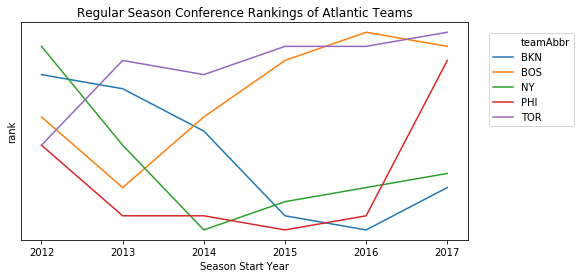

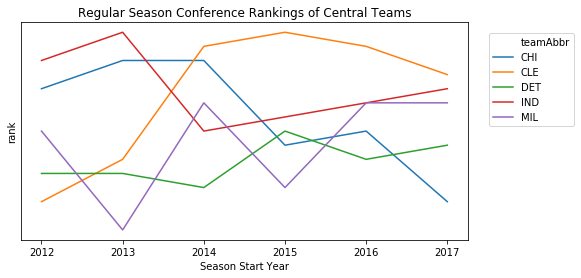

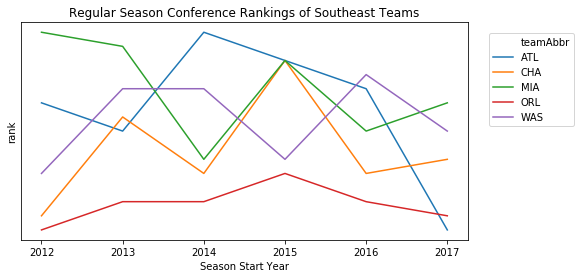

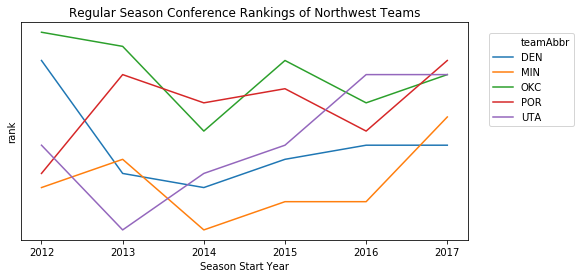

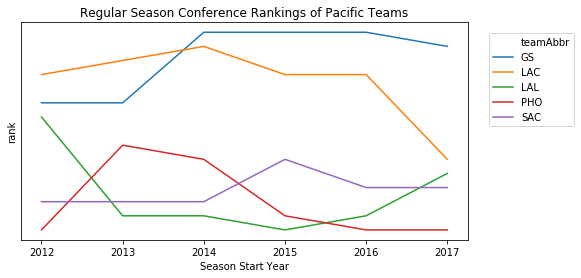

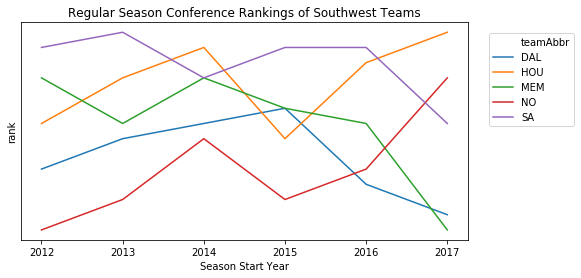

In [11]:
# list of all possible divisions
divisions = ['Atlantic', 'Central', 'Southeast', 'Northwest', 'Pacific', 'Southwest']

# plotting for the separate divisions
for division in divisions:
    plt.figure(figsize=(8, 4))
    atlantic = sns.lineplot('startYear', 'rank', data=division_rankings[division_rankings['teamDiv'] == division], 
                            hue='teamAbbr')
    atlantic.legend(loc='lower right', bbox_to_anchor=(1.25, 0.5), ncol=1)
    plt.title('Regular Season Conference Rankings of {} Teams'.format(division))
    plt.xlabel('Season Start Year')
    plt.yticks(range(1))
    
    # inverting y axis because lower ranks are better, makes the visualization more intuitive
    plt.gca().invert_yaxis()
    plt.show();

These visualizations show us that most teams tend to either fluctuate around the same standings or progressively trend towards one direction. Teams that 'spike' between positions (like Milwaukee in the Central division) or that quickly rise up the standings (like Philadelphia in the Atlantic division from the 16/17 to 17/18 season) are pretty uncommon. Without rigorous proof, we can see that these 'trends' do exist.

After some external research, we discovered that sudden team improvements (like the 76ers and Bucks mentioned above) are largely due to obtaining leverage after obtaining high draft picks in the draft lottery (either through getting a new young talent to build a team around, or trading for better components). For example, the 76ers had just drafted Ben Simmons in the 2016 Draft and the Bucks were finally seeing great production from Giannis.

### 3. Feature Engineering/More EDA

Now, we want to discover which features are most correlated to success, potentially identify redudancy/multicollinearity, and identify significant features that our data doesn't fully address.

In [12]:
# add a column of whether the team made playoffs in the next season
# 2018-19 season playoffs data which is manually inputted from NBA.com
season_1819 = pd.DataFrame()
season_1819['teamAbbr'] = rankings.index.get_level_values('teamAbbr').unique().tolist()
season_1819['playoffs'] = [0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0]
season_1819['season'] = ['2018/19'] * len(season_1819)
seasons_playoff = all_data['playoffs'].reset_index()
seasons_playoff.append(season_1819)

# remove the 2012-13 season data
seasons_playoff = seasons_playoff[seasons_playoff['season'] != '2012/13']
seasons_playoff.columns = ['next_season', 'teamAbbr', 'next_playoffs']

In [13]:
def addNextSeason(df):
    """
    df: selected Pandas Dataframe
    
    return: augmented version of df that includes a column for the next season label
    """
    # map current season to next season
    dates_dict = {'2012/13': '2013/14', \
                 '2013/14': '2014/15', \
                 '2014/15': '2015/16', \
                 '2015/16': '2016/17', \
                 '2016/17': '2017/18', \
                 '2017/18': '2018/19'}
    
    df_new = pd.DataFrame(df.to_records())

    df_new['next_season'] = df_new['season'].map(dates_dict)
    return df_new.merge(seasons_playoff, how='inner', on=['teamAbbr', 'next_season'])

NB: We will now split our data into training and test data so that our feature engineering is based only on our training data.

In [14]:
# configure our training data
training_data = addNextSeason(all_data)
X = training_data.drop(columns = 'next_playoffs')
y = training_data['next_playoffs']

# split off a portion of the data to use as test data. Shuffling is done automatically done
train_x_all, test_x_all, train_y, test_y = train_test_split(X, y, test_size=0.15, random_state=9)

# drop unnecessary columns
train_x = train_x_all.drop(columns= ['season', 'teamAbbr', 'next_season']) 
test_x = test_x_all.drop(columns= ['season', 'teamAbbr', 'next_season']) 

# standardize
train_x = (train_x - np.mean(train_x)) / np.std(train_x)
test_x = (test_x - np.mean(test_x)) / np.std(test_x)

# fill NaNs in the overtime columns with 0, as analyzed below
train_x[['teamPTS5', 'teamPTS6', 'teamPTS7', 'teamPTS8']].fillna(0, inplace=True)
test_x[['teamPTS5', 'teamPTS6', 'teamPTS7', 'teamPTS8']].fillna(0, inplace=True)

Here, we make a crucial observation. Namely, the 'teamPTS5' to 'teamPTS8' columns represents points only for games that went to overtime to quadruple overtime. These are rare events, and there's a possibility that our dataframes actually contain no games for these categories. When we try to standardize it, we will get NaNs (0/0, this causes the bits in the floating point to be representative of a NaN).

Hence, we will simply fill those columns column with all 0s as a precaution, since we know the only way to get a 0/0 is if the standard deviation was 0, which implies the result was deterministic.

Now, let's see which of our current features is most correlated with playoff qualification.

In [15]:
# finding the top 15 features in correlation magnitude with next year playoff qualification
# We start the index at 1 to remove the perfect correlation between next_playoff and itself
correlation_data = train_x.copy()
correlation_data['next_playoffs'] = train_y
correlation_data.corr()['next_playoffs'].abs().sort_values(ascending=False)[1:16]

teamEDiff    0.537729
Win          0.536467
playoffs     0.476470
teamDrtg     0.402753
teamOrtg     0.385876
teamFIC      0.363386
teamFIC40    0.358654
teamTS%      0.345768
teamEFG%     0.336672
teamPlay%    0.332069
team3P%      0.325270
teamPPS      0.324089
teamFG%      0.311550
team2P%      0.294494
teamPTS1     0.289517
Name: next_playoffs, dtype: float64

To gain a better understanding of the nuances of our question (and for curiosity's sake), let's also take a look at the worst features.

In [16]:
# finding the worst 10 features in correlation magnitude with next year playoff qualification
correlation_data.corr()['next_playoffs'].abs().sort_values()[:10]

teamPTS7     0.003253
teamPF       0.007670
team2PM      0.015689
teamPTS6     0.019972
teamDREB%    0.031375
teamORB      0.042253
teamTO%      0.058717
teamFTA      0.065448
teamOREB%    0.065828
teamFGA      0.071920
Name: next_playoffs, dtype: float64

Some of these findings are largely intuitive. For example, we would expect that teams with more wins or with more recent playoff experience will naturally do better, as both can serve as direct proxys for the relative strength of a team. On the other hand, statistics like shot attempts matter far less than the percentage made. Efficiency is key.

Moreover, we see the importance of defensive rating (in addition to only the offense parts of the game). However, some of these findings are counter-intuitive. The most baffling to us, however, is how rebounding and turnovers - commonly emphasized by sports analysts and pundits for maximizing the number of offensive possesions and minimizing the opponent's scoring - didn't seem to play a huge factor. Interestingly enough, for an era of the game that glorifies point guards, team assists and its respective ratios, are not that correlated with playoff qualification. We hypothesize this could be because with relative even scoring, most field goals will be assisted in some way or another. This statistic is not really a good quantification of teamwork, passing ability, or offense prowess. 

One thing that isn't that surprising, however, was the fact that in an era of the game where 3-point shooting is of paramount importance, it's highly influential. We hypothesized that it may be that this transitioned happened over time given our data, and was an (small) tangent we wanted to expolore in more detail. Let's take a look to see if time is a factor that relates to this surprising phenomenon with 3-point shooting.

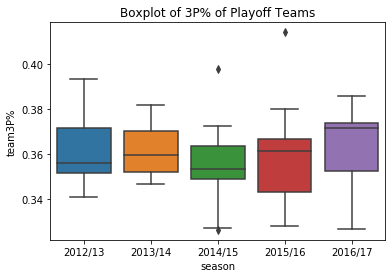

In [17]:
# create a dataframe of all playoff teams and graph a boxplot of their 3P%
playoff_teams = train_x_all[train_x_all['playoffs'] == 1]
playoff_teams = pd.DataFrame(playoff_teams.to_records())
sns.boxplot('season', 'team3P%', data=playoff_teams, 
            order=['2012/13', '2013/14', '2014/15', '2015/16', '2016/17'])
plt.title("Boxplot of 3P% of Playoff Teams");

Wonder who that insane outlier that shot over 41% collectively as a team (2015/16 season) is? I think most casual NBA fans in the Bay Area can accurately guess.

In [18]:
playoff_teams[playoff_teams['team3P%'] > 0.41]['teamAbbr']

50    GS
Name: teamAbbr, dtype: object

We should note that some teams that make the playoffs still shoot horribly from outside the arc. For example, in 2016/17 one team shot atrociously bad from 3-point land.

In [19]:
playoff_teams[(playoff_teams['team3P%'] < 0.33) & (playoff_teams['season'] == '2016/17')]['teamAbbr']

14    OKC
Name: teamAbbr, dtype: object

Which honestly shouldn't be a surprise when you realize Russel Westbrook shot an average of 7.2	3s per game at only 34.3%. 

Source: https://www.basketball-reference.com/players/w/westbru01.html

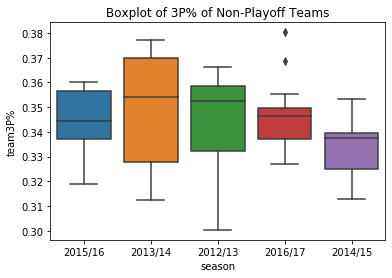

In [20]:
# create a dataframe of all non-playoff teams and graph a boxplot of their 3P%
non_playoff_teams = train_x_all[train_x_all['playoffs'] == 0]
non_playoff_teams = pd.DataFrame(non_playoff_teams.to_records())
sns.boxplot('season', 'team3P%', data=non_playoff_teams)
plt.title("Boxplot of 3P% of Non-Playoff Teams");

We also notice that a large majority of high correlation magnitudes are based on shooting efficiency. We hypothesize that there's probably much redundancy in these features.

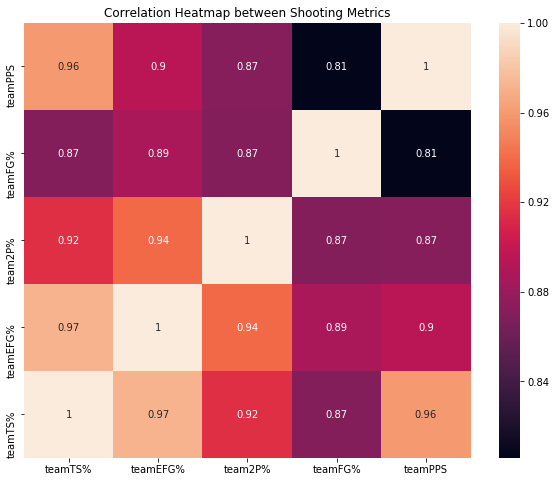

In [21]:
# a list of shooting metrics we'll analyze
shooting_metrics = training_data[['teamTS%', 'teamEFG%', 'team2P%', 'teamFG%', 'teamPPS']]

# create a correlation heatmap between those features
plt.figure(figsize=(10, 8))
shot_heatmap = sns.heatmap(shooting_metrics.corr(), annot=True)
plt.title("Correlation Heatmap between Shooting Metrics")

# this line of code below fixes a sns.heatmap bug with newer iterations of matplotlib
shot_heatmap.set_ylim(0, 5);

Unsurprisingly, these features are highly correlated. We should probably only use one. We choose True Shooting Percentage because it's both the highest correlated and the best comprehensive metric for all shooting efficiency.

We now go through all the possible features again, repeat this process, and pick out a set of features that are both indicative, and uncorrelated with each other. An interesting observation from the heatmap below is that defensive rating seems to be negatively correlated with playoff contention. This seems counter-intuitive; after all, "defense wins championships." It's worth noting that lower defensive ratings are actually better (i.e. lower scores mean better defenses) given the NBA's definition. Hence, it's not really that counterintuitive.

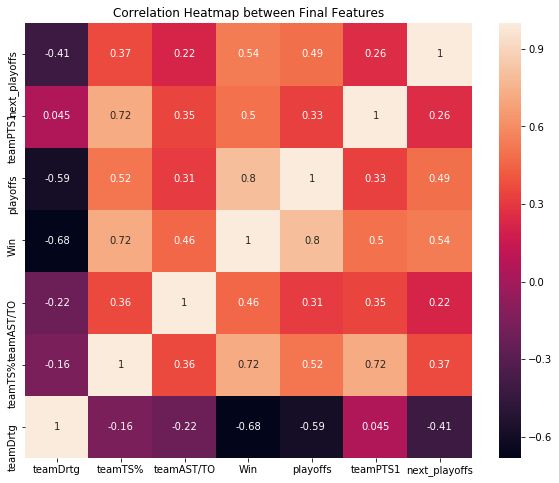

In [22]:
# final_features = ['Win', 'playoffs', 'teamDrtg', 'teamTS%']
# final_features = ['Win', 'playoffs', 'teamDrtg', 'teamOrtg', 'teamPTS7', 'teamBLK%']
# final_features = ['teamTRB', 'teamPF', 'playoffs', 'teamDrtg', 'teamDRB', 'Win']     
# final_features = ['teamSTL/TO', 'teamAR', 'teamORB', 'teamDrtg', 'teamFG%', 'playoffs']
# final_features = ['teamTO%', 'teamTRB', 'teamPF', 'teamDrtg', 'teamFG%', 'playoffs']

# our final feature selection
final_features = ['teamDrtg', 'teamTS%', 'teamAST/TO', 'Win', 'playoffs', 'teamPTS1']

# create the correlation heatmap
final_mov_avg = training_data[final_features + ['next_playoffs']]
plt.figure(figsize=(10, 8))
shot_heatmap = sns.heatmap(final_mov_avg.corr(), annot=True)
plt.title("Correlation Heatmap between Final Features")

# this line of code below fixes a sns.heatmap bug with newer iterations of matplotlib
shot_heatmap.set_ylim(0, 7);

Even after selecting highly correlated features that have seemingly little to do with each other at first glance, there's still a significant amount of redundancy.

### 4. Initial Model Selection

Let's try to fit a diverse range of models to see how well we can predict NBA playoff qualification with only our given dataset

#### Model 4.1: Naive Baseline Predictor

We'll create a baseline predictor that simply predicts playoff qualification based on past season's performance (i.e. teams who made the playoffs in the past will make it again).

In [23]:
class naive_predictor:
    def init(self):
        pass
    
    def fit(self, X, y):
        self.X = X
        self.y = y
    
    def score(self):
        prediction_df = self.X.merge(self.y, on='teamAbbr')
        return np.average(prediction_df['playoffs'] == prediction_df['next_playoffs'])

baseline = naive_predictor()
baseline_X = X[X['season'] == '2012/13']
baseline_y = training_data[training_data['season'] != '2012/13'][['teamAbbr', 'next_playoffs']]
baseline.fit(baseline_X, baseline_y)
baseline_score = baseline.score()
baseline_score

0.6083333333333333

Roughly 61% accuracy is decent for a baseline/naive predictor. It does beat guessing at random (which would converge to a 50% accuracy). Let's see if we can make our predictor more sophisticated in future iterations.

#### Model 4.2a: Logistic Regression with Feature Selection

We'll now perform logistic regression on our selected features.

The best hyperparamter C is:  2.163265306122449
The best cross-validation accuracy is:  0.748


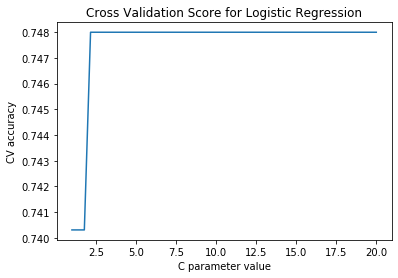

In [24]:
# select the final features
train_x_cleaned = train_x[final_features]

# hyperparameter tuning and tracking CV
c_vals = np.linspace(1, 20, 50)
logreg_score = []
for c in c_vals:
    logreg_naive = LogisticRegression(C=c, random_state=9)
    logreg_score.append(np.mean(cross_val_score(logreg_naive, train_x_cleaned, train_y, cv=5)))

# plot the CV with different values of c
plt.plot(c_vals, logreg_score)
plt.title('Cross Validation Score for Logistic Regression')
plt.xlabel('C parameter value')
plt.ylabel('CV accuracy');

# identify the best hyperparameter and CV accuracy
best_C = c_vals[np.argmax(logreg_score)]
best_logreg_CV = max(logreg_score)
print("The best hyperparamter C is: ", best_C)
print("The best cross-validation accuracy is: ", best_logreg_CV)

#### Model 4.2b: Decision Tree Classifier with Feature Selection

In [25]:
# create one decision tree (for curiosity's sake)
decisiontree_naive = DecisionTreeClassifier(random_state=9)
decisiontree_score_CV = np.mean(cross_val_score(decisiontree_naive, train_x_cleaned, train_y, cv=5))
print('The cross validation accuracy of decision tree is: ', decisiontree_score_CV)

The cross validation accuracy of decision tree is:  0.583076923076923


Note, the lower CV score is expected due to the nature of decision trees to overfit.

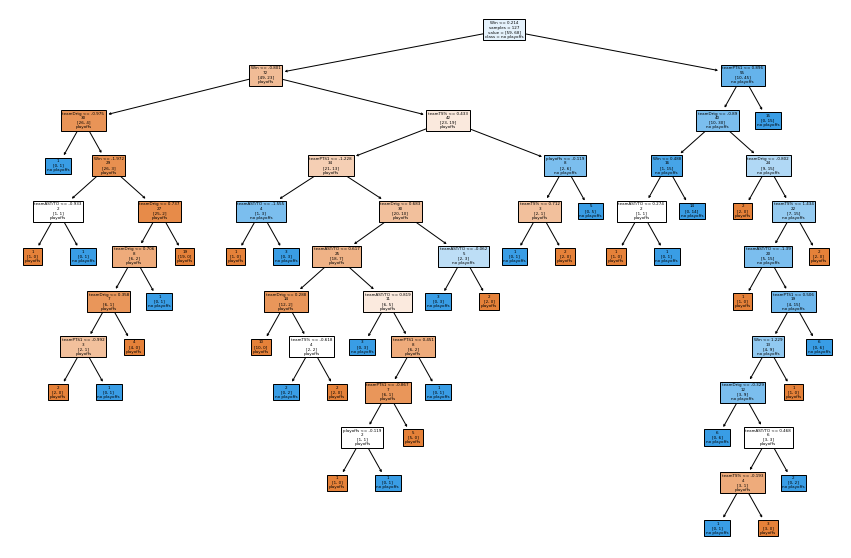

In [26]:
# create a visualization of the decision tree
decisiontree_naive.fit(train_x_cleaned, train_y)
plt.figure(figsize=(15,10))
plot_tree(decisiontree_naive, feature_names = train_x_cleaned.columns, \
          filled=True, label='root', \
          impurity=False, \
         class_names = ['playoffs', 'no playoffs']);

#### Model 4.2c: Random Forest Classifier with Feature Selection

In [27]:
# setting the range of possible hyperparameters
depths = np.linspace(1, 5, 5)
num_trees = [1, 5, 10, 100, 1000]
max_features = ['auto', 'log2', None]
randomforest_scores = []
rf_best_depth = float('-inf')
rf_best_num_trees = float('-inf')
rf_best_split = float('-inf')
rf_max_score_CV = float('-inf')

# hyperparameter tuning
for depth in depths:
    for n in num_trees:
        for m in max_features:
            randomforest = RandomForestClassifier(max_depth = depth, n_estimators=n, random_state=9, \
                                                  max_features=m)
            curr = np.mean(cross_val_score(randomforest, train_x_cleaned, train_y, cv=5))
            if curr >= rf_max_score_CV:
                rf_best_depth = depth
                rf_best_num_trees = n
                rf_max_score_CV = curr
                rf_best_split= m
                
# identify the best hyperparameter and CV accuracy
print('The best cross validation score for random forest is: ', rf_max_score_CV)
print('The best depth to use is: ', rf_best_depth)
print('The best number of trees to use is: ', rf_best_num_trees)
print('The best number of splits to use is: ', rf_best_split)

The best cross validation score for random forest is:  0.7486153846153846
The best depth to use is:  3.0
The best number of trees to use is:  1000
The best number of splits to use is:  log2


#### Model 4.3: KNN

Let's go above and beyond and incorporate a (largely underrated) classification scheme.

The best cross validation accuracy of K-NN is:  0.7006153846153846


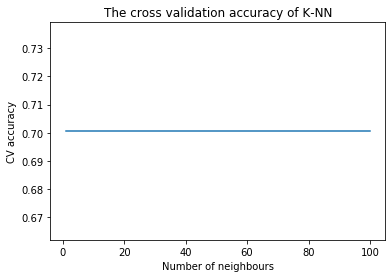

In [28]:
# tune for optimal number of neighbours
num_neighbours = [1, 5, 10, 20, 50, 100]
neigh_score= []
for n in num_neighbours:
    neigh = KNeighborsClassifier()
    neigh_score.append(np.mean(cross_val_score(neigh, train_x_cleaned, train_y, cv=5)))
    
# plot the CV with different number of neighbors considered
plt.plot(num_neighbours, neigh_score)
plt.title('The cross validation accuracy of K-NN')
plt.xlabel('Number of neighbours')
plt.ylabel('CV accuracy');
knn_CV = max(neigh_score)
print('The best cross validation accuracy of K-NN is: ', knn_CV)

### 5. Additional Feature Engineering

To find ways to improve our models, we should probably take a look at the teams where our best performing classifier (the logistic regression) didn't guess right.

#### 5.1.1 PCA analysis

In [29]:
# fit and predict
lr = LogisticRegression(C=best_C, random_state=9)
lr.fit(train_x_cleaned, train_y)
predictions = lr.predict(train_x_cleaned)

# find the wrong predictions
idx = predictions != train_y.values
team_info = train_x_all[idx]
wrong_X = team_info.drop(['season', 'teamAbbr', 'next_season'], axis=1)

# standardize
wrong_X = pd.DataFrame(StandardScaler().fit_transform(wrong_X), 
                           columns=wrong_X.columns, index=wrong_X.index)

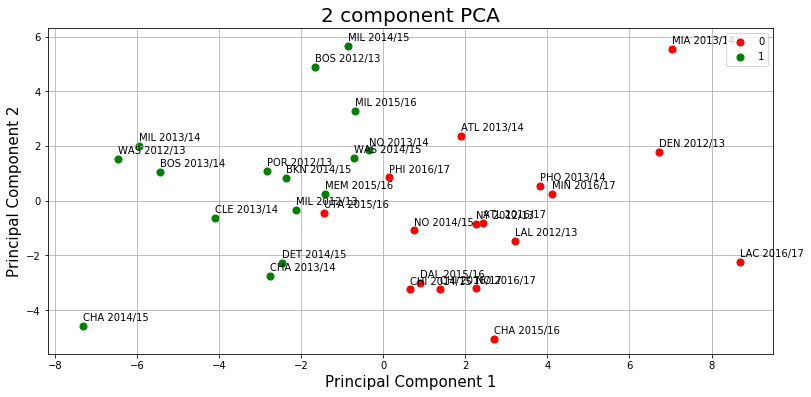

In [30]:
clustering = AgglomerativeClustering(n_clusters=2).fit(wrong_X)
clustering_pca = PCA(2)
principal_df = pd.DataFrame(data = clustering_pca.fit_transform(wrong_X), columns = ['PC 1', 'PC 2'], index=wrong_X.index)
principal_df['cluster'] = clustering.labels_
principal_df['team'] = team_info['teamAbbr']

# the team label includes team name and season
principal_df['team'] = principal_df.team.map(str) + " " + team_info['season']

# inspiration source: https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
fig = plt.figure(figsize = (13,6))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0, 1]
colors = ['r', 'g']
for target, color in zip(targets, colors):
    indicesToKeep = principal_df['cluster'] == target
    ax.scatter(principal_df.loc[indicesToKeep, 'PC 1']
               ,principal_df.loc[indicesToKeep, 'PC 2']
               ,c = color
               ,s = 50)
    
indices = principal_df.index.to_list()
for i, label in enumerate(principal_df['team']):
    x = principal_df.loc[indices[i], 'PC 1']
    y = principal_df.loc[indices[i], 'PC 2']
    ax.annotate(label, (x, y+0.2)) 

ax.legend(targets)
ax.grid()

We did some external research to see what could have caused these incorrect projections for these teams. We also tried tuning the number of clusters. Ultimately, nothing really came out of this tactic. We simply could not find the relationship between the clustered teams. Though we are both casual basketball fans, we probably didn't have enough domain knowledge to be able to tie these specific teams and their performance in their respective seasons together.

Nonetheless, using the insights drawn from earlier EDA, we recognized that draft prospects was an off-court factor that contributes heavily to a team's success. We also hypothesize that individual players might carry a tremendous influence. We will use salary cap (not as in the hard cap for salaries, but how much is being paid out in salary to players) as a proxy for this. The following cells includes our process of gathering and parsing additional data.

#### 5.1.2 Additional Data To get Draft Pick and Salary Cap

From a dataset on Kaggle, we cleaned it to extract the relevant round 1 draft picks for each team in each season.

In [31]:
# @source: https://www.kaggle.com/hrfang1995/nba-drafts-of-19472018#NBA_Full_Draft_1947-2018.csv
drafts = pd.read_csv('NBA_Full_Draft_1947-2018.csv')

In [32]:
# selecting relevant years
drafts = drafts[drafts['Year'] >= 2012]
drafts = drafts[drafts['Year'] < 2018]
drafts = pd.DataFrame(drafts.groupby(['Team', 'Year'])['Pick'].min().to_frame().to_records())

team_drafts = drafts[['Team', 'Year', 'Pick']]

In [33]:
# necessary dictionaries to keep data labels consistent
team_dict = {'ATL': 'ATL', \
    'BRK': 'BKN' ,\
    'BOS': 'BOS', \
    'CHA': 'CHA', \
    'CLE': 'CLE', \
    'CHI': 'CHI', \
    'DAL': 'DAL', \
    'DEN': 'DEN', \
    'DET': 'DET', \
    'HOU': 'HOU', \
    'IND': 'IND', \
    'GSW': 'GS', \
    'IND': 'IND', \
    'LAL': 'LAL', \
    'LAC': 'LAC', \
    'MEM': 'MEM', \
    'MIA': 'MIA', \
    'NOH': 'NO', \
    'NOP': 'NO', \
    'NYK': 'NY', \
    'ORL': 'ORL', \
    'SAS': 'SA', \
    'MIL': 'MIL', \
    'MIN': 'MIN', \
    'OKC': 'OKC', \
    'PHI': 'PHI', \
    'PHO': 'PHO', \
    'POR': 'POR', \
    'SAC': 'SAC', \
    'TOR': 'TOR', \
    'UTA': 'UTA', \
    'WAS': 'WAS', \
    'CHH': 'CHA'
}

seasons_dict = {
    2012: '2012/13', \
    2013: '2013/14', \
    2014: '2014/15', \
    2015: '2015/16', \
    2016: '2016/17', \
    2017: '2017/18', \
    2018: '2018/19'    
}

In [34]:
# replace incosistent labels
team_drafts.replace({'Team': team_dict, 'Year': seasons_dict}, inplace=True)

We web-scraped the salary caps for each team over each season

In [35]:
# web-scrape salary cap information
# @source: https://hoopshype.com/salaries/
salary = []
for year1, year2 in [('2012', '2013'), ('2013', '2014'), ('2014', '2015'), ('2015', '2016'), ('2016', '2017'), ('2017', '2018')]:
        curr = pd.read_html('https://hoopshype.com/salaries/' + year1 + '-' + year2 + '/')[0]        
        curr = curr.iloc[:, [1,3]]
        curr.rename(columns= lambda x: re.sub('\(\*\)','',x), inplace=True)
        curr['season'] = [curr.columns[1]] * len(curr)
        curr.columns =  ['Team', 'salarycap', 'season']
        salary.append(curr)
salary_df = pd.concat(salary)

In [36]:
# more dictionaries to keep label consistency
team_name_dict2 = {
    'Atlanta': 'ATL', \
    'Brooklyn': 'BKN' ,\
    'Boston': 'BOS', \
    'Charlotte': 'CHA', \
    'Cleveland': 'CLE', \
    'Chicago': 'CHI', \
    'Dallas': 'DAL', \
    'Denver': 'DEN', \
    'Detroit': 'DET', \
    'Houston': 'HOU', \
    'Indiana': 'IND', \
    'Golden State': 'GS', \
    'LA Lakers': 'LAL', \
    'LA Clippers': 'LAC', \
    'Memphis': 'MEM', \
    'Miami': 'MIA', \
    'New Orleans': 'NO', \
    'New York': 'NY', \
    'Orlando': 'ORL', \
    'San Antonio': 'SA', \
    'Milwaukee': 'MIL', \
    'Minnesota': 'MIN', \
    'Oklahoma City': 'OKC', \
    'Philadelphia': 'PHI', \
    'Phoenix': 'PHO', \
    'Portland': 'POR', \
    'Sacramento': 'SAC', \
    'Toronto': 'TOR', \
    'Utah': 'UTA', \
    'Washington': 'WAS'}

In [37]:
# Adjust all the team names to be consistent with original data and alter salaries to integers
salary_df.replace({'Team': team_name_dict2}, inplace=True)
salarycap_int = [int(re.sub(r'[^\d.]', '', amt)) for amt in salary_df['salarycap'].to_list()]
salary_df['salarycap'] = salarycap_int

In [38]:
# Merge the additional data
draft_cap = pd.merge(salary_df, team_drafts, how='outer', left_on = ['Team', 'season'], right_on = ['Team', 'Year'])
draft_cap.drop(columns=['Year'], inplace=True)

In [39]:
# clean draft and salary data to aggregate and index by team and season
draft_cap.rename(columns={'Team': 'teamAbbr'}, inplace=True)
draft_cap.groupby(['season', 'teamAbbr']).mean()
draft_cap.set_index(['season', 'teamAbbr'], inplace= True)
draft_cap = draft_cap.fillna(61)
draft_cap.head()

salarycap  Pick
season  teamAbbr                   
2012/13 LAL       111767168.0  60.0
        BKN        97828818.0  61.0
        MIA        89773532.0  27.0
        NY         89270334.0  48.0
        BOS        84282350.0  21.0

In [40]:
# join draft data with training and test data
draft_cap_flat = pd.DataFrame(draft_cap.to_records())
train_x_all = train_x_all.merge(draft_cap_flat, how='left', on=['season', 'teamAbbr'])
test_x_all = test_x_all.merge(draft_cap_flat, how='left', on=['season', 'teamAbbr'])

### 6. Additional Models 

In [56]:
# drop unncessary columns
aug_train_x_initial = train_x_all.drop(columns= ['season', 'teamAbbr', 'next_season']) 
aug_test_x_initial = test_x_all.drop(columns= ['season', 'teamAbbr', 'next_season']) 

# standardize the data
aug_train_x = (aug_train_x_initial - np.mean(aug_train_x_initial)) / np.std(aug_train_x_initial)
aug_test_x = (aug_test_x_initial - np.mean(aug_test_x_initial)) / np.std(aug_test_x_initial)

# fill NaNs in the quadruple overtime column with 0
aug_train_x['teamPTS8'].fillna(0, inplace=True)
aug_test_x['teamPTS8'].fillna(0, inplace=True)

#### 6.1 Re-doing Logistic Regression with draft pick and salary cap

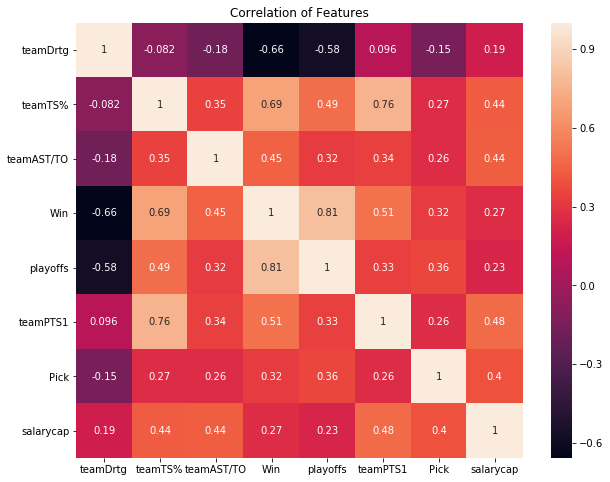

In [42]:
# revisualize the correlation heatmap
plt.figure(figsize=(10,8))
plt.title('Correlation of Features')
sns.heatmap(aug_train_x[final_features + ['Pick', 'salarycap']].corr(), annot=True);

Interestingly enough, pick and salarycap are correlated with one another. We believe this might be the case because younger players typically demand lower-priced contracts, leading to less money being paid out. This is an interesting correlation we didn't really expect to see. 

The best hyperparamter C is:  1.3877551020408163
The best cross-validation accuracy:  0.7323076923076923


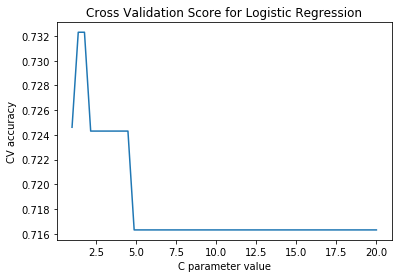

In [43]:
# take only necessary columns
aug_train_x_cleaned = aug_train_x[final_features + ['Pick', 'salarycap']]

# tuning the hyperparameter
c_vals = np.linspace(1, 20, 50)
aug_logreg_score = []
for c in c_vals:
    logreg_draft_cap= LogisticRegression(C=c)
    aug_logreg_score.append(np.mean(cross_val_score(logreg_draft_cap, aug_train_x_cleaned, train_y, cv=5)))

# plotting the CV scores based on given c value
plt.plot(c_vals, aug_logreg_score)
plt.title('Cross Validation Score for Logistic Regression')
plt.xlabel('C parameter value')
plt.ylabel('CV accuracy');

# listing the best hyperparameter value and respective CV score
aug_best_c = c_vals[np.argmax(aug_logreg_score)]
aug_logreg_CV = max(aug_logreg_score)
print("The best hyperparamter C is: ", aug_best_c)
print("The best cross-validation accuracy: ", aug_logreg_CV)

#### 6.2 Using PCA + logistic regression
This uses the original train_x (of all features) and tries to find the best features on its own via PCA. We realized that our own choice of features (especially with the new additions that are somewhat correlated) might not be the best. We use PCA as a systematic way to select linear combinations of these features -- hopefully in a better manner than we originally did.

In [44]:
# tuning the hyperparameter
pcas = [1, 5, 15, 20, 25, 30, 50]
c_vals = np.linspace(1, 20, 50)
pca_lr_score = []
pca_cs = []
for val in pcas:
    for c in c_vals:
        pca_cs.append((val, c))
        pca = PCA(val)
        logistic = LogisticRegression(C=c)
        pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])
        pca_lr_score.append(np.mean(cross_val_score(pipe, aug_train_x, train_y, cv=5)))

# listing the best hyperparameter value and respective CV score
pca_logreg_CV = max(pca_lr_score)
print('PCA + logistic regression cross validation accuracy: ',pca_logreg_CV)
best_pca, best_c = pca_cs[np.argmax(pca_lr_score)]
print('The best pca rank limit is: ', best_pca)
print('The best C for Logistic regression is: ', best_c)

PCA + logistic regression cross validation accuracy:  0.7316923076923076
The best pca rank limit is:  5
The best C for Logistic regression is:  1.0


#### 6.3 Random Forest with new features

In [45]:
# tuning the hyperparameter
depths = np.linspace(1, 5, 5)
num_trees = [1, 5, 10, 100, 1000]
max_features = ['auto', 'log2', None]
rf_best_depth_nf = -100
rf_best_num_trees_nf = -100
rf_best_split_nf = -100
rf_max_score_CV_nf = float('-inf')
for depth in depths:
    for n in num_trees:
        for m in max_features:
            randomforest = RandomForestClassifier(max_depth = depth, n_estimators=n, random_state=9, \
                                                  max_features=m)
            curr = np.mean(cross_val_score(randomforest, aug_train_x, train_y, cv=5))
            if curr >= rf_max_score_CV_nf:
                rf_best_depth_nf = depth
                rf_best_num_trees_nf = n
                rf_max_score_CV_nf = curr
                rf_best_split_nf= m
                
# listing the best hyperparameter value and respective CV score
print('The best cross validation score for random forest is: ', rf_max_score_CV_nf)
print('The best depth to use is: ', rf_best_depth_nf)
print('The best number of trees to use is: ', rf_best_num_trees_nf)
print('The best number of splits to use is: ', rf_best_split_nf)

The best cross validation score for random forest is:  0.7329230769230769
The best depth to use is:  2.0
The best number of trees to use is:  100
The best number of splits to use is:  auto


### 7. All Model Test Results

All the following test models are run on the best parameters found from cross validations above

#### 7.1 Logistic Regression (uses original feature selection)

In [46]:
logreg_naive = LogisticRegression(C=best_C, random_state=9)
logreg_naive.fit(train_x_cleaned, train_y)
logreg_preds = logreg_naive.predict(test_x[final_features])
logreg_accuracy = accuracy_score(test_y, logreg_preds)
print('The test accuracy of logistic regression is: ', logreg_accuracy)

The test accuracy of logistic regression is:  0.7391304347826086


#### 7.2 Decision Tree (uses original feature selection)

In [47]:
decisiontree_naive= DecisionTreeClassifier(random_state=9)
decisiontree_naive.fit(train_x_cleaned, train_y)
decisiontree_preds = decisiontree_naive.predict(test_x[final_features])
decisiontree_accuracy = accuracy_score(test_y, decisiontree_preds)
print('The test accuracy of decision tree is: ', decisiontree_accuracy)

The test accuracy of decision tree is:  0.4782608695652174


#### 7.3.1 Random Forest 1 (uses original feature selection)

In [48]:
randomforest = RandomForestClassifier(max_depth = rf_best_depth, n_estimators=rf_best_num_trees, random_state=9, \
                                     max_features=rf_best_split)
randomforest.fit(train_x, train_y)
randomforest_preds = randomforest.predict(test_x)
randomforest_accuracy = accuracy_score(test_y, randomforest_preds)
print('The test accuracy of random forest is: ', randomforest_accuracy)

The test accuracy of random forest is:  0.6956521739130435


#### 7.3.2 Random Forest 2 (includes new data)

In [49]:
randomforest_2 = RandomForestClassifier(max_depth = rf_best_depth_nf, n_estimators=rf_best_num_trees_nf, \
                                        random_state=9, max_features=rf_best_split_nf)
randomforest_2.fit(aug_train_x, train_y)
randomforest_preds_2 = randomforest_2.predict(aug_test_x)
randomforest_accuracy_2 = accuracy_score(test_y, randomforest_preds_2)
print('The test accuracy of random forest is: ', randomforest_accuracy_2)

The test accuracy of random forest is:  0.7391304347826086


#### 7.4 KNN (uses original feature selection)

In [50]:
neigh = KNeighborsClassifier(n_neighbors= 5)
neigh.fit(train_x_cleaned, train_y)
neigh_preds = neigh.predict(test_x[final_features])
neigh_accuracy = accuracy_score(test_y, neigh_preds)
print('The test accuracy of K-NN is: ', neigh_accuracy)

The test accuracy of K-NN is:  0.7391304347826086


#### 7.5 Logistic Regression 2 (includes new data)

In [51]:
logreg_draft_cap = LogisticRegression(C=aug_best_c)
logreg_draft_cap.fit(aug_train_x_cleaned, train_y)
logreg_draft_cap_preds = logreg_draft_cap.predict(aug_test_x[final_features + ['Pick', 'salarycap']])
logreg_draft_cap_accuracy = accuracy_score(test_y, logreg_draft_cap_preds)
print('The test accuracy for Logistic Regression with the additional features is: ', logreg_draft_cap_accuracy)

The test accuracy for Logistic Regression with the additional features is:  0.6521739130434783


#### 7.6 Logistic Regression 3 (PCA on new data)

In [62]:
pca_best = PCA(best_pca)
logistic_pca = LogisticRegression(C=best_c, max_iter=10000, tol=0.5)
logistic_pca.fit(pca_best.fit_transform(aug_train_x), train_y)

aug_test_x_centered = (aug_test_x_initial - np.mean(aug_train_x_initial)) / np.std(aug_train_x_initial)
pca_lr_test = pca_best.transform(aug_test_x_centered)

pipe_preds = logistic_pca.predict(pca_lr_test)
pipe_accuracy = accuracy_score(test_y, pipe_preds)
print('The test accuracy of PCA with Logistic Regression is: ', pipe_accuracy)

The test accuracy of PCA with Logistic Regression is:  0.782608695652174


#### 7.7 Comparison of Models

In [63]:
model_names = ['Baseline', 'Original LogReg', 'Decision Tree', 'Original Random Forest',
               'KNN', 'New LogReg', 'New LogReg with PCA', 'New Random Forest']
cross_validation = [0, best_logreg_CV, decisiontree_score_CV, rf_max_score_CV, knn_CV, aug_logreg_CV,
                    pca_logreg_CV, rf_max_score_CV_nf]
test_accuracy = [baseline_score, logreg_accuracy, decisiontree_accuracy, randomforest_accuracy,
                  neigh_accuracy, logreg_draft_cap_accuracy, pipe_accuracy, randomforest_accuracy_2]

fig = go.Figure([go.Bar(x=model_names, y=cross_validation, name="Cross Validation Accuracy"), 
           go.Bar(x=model_names, y=test_accuracy, name="Test Accuracy")])
fig.update_layout(
    title="Comparison of CV Accuracy and Test Accuracy",
    xaxis_title="Model",
    yaxis_title="Accuracy",
    font=dict(
        family="Times New Roman",
        size=13    
    )
)
fig.update_yaxes(range=[0,1])

### 8. Conclusions and Final Analysis

Though we didn't even achieve better than 80% accuracy, we believe the question we posed at the very beginning is fundamentally really difficult. After all, if incredibly accurate predictors existed, the thrill of a NBA season would likely be taken away. What we have shown, however, is that it is possible to use sophisticated measures to improve on a naive baseline, by a non-trivial amount.

The difference between our old (no draft and salary cap info) and new (with draft and salary cap info) models, highlights how difficult it is to quantify off-court impact. Our manually selected logistic regression model actually performs worse on cross validation and test accuracy, though when we leave the feature selection up to SVD and PCA, it does much better. This could be because our newly introduced features are correlated with each other, or with the features we already selected (which they in fact are). Since so much of basketball is intertwined, it's very difficult to fight this multicollinearity.

The decision tree, not surprisingly, did incredibly bad (worse than our baseline)! This should simply reinforce the idea that a singular decision tree overfits incredibly, and will perform horribly on new data.

If we were to select and 'ship' one of these models, we would probably choose the logistic regression with PCA. Not only does it perform best, but since it is parametric, it will scale in the future (i.e. it won't be dependent on the amount of data we feed it, which will constantly evolve).

We believe these models could be improved through more data. When we actually aggregated our box score data into team and season, the size of our dataset dwindled. More data is always better, though we would have to be cautious and do more research on how the game of basketball evolved through the past few decades to utilize that data to its full potential.

Ultimately, we seeked to determine if calculated decisions could create an accurate playoff qualification predictor. We believe that with such a complex environment and with some a complex question, our models perform fairly well, and are 'fairly accurate.' Individuals who have more domain knowledge and access to a greater database could definitely outperform us, though our work serves as a baseline to demonstrate through example that it is possible.

### Questions
– (i) What were two or three of the most interesting features you came across for your particular
question? <br>

– (ii) Describe one feature you thought would be useful, but turned out to be ineffective. <br>
    - a lot of the features were correlated. eg. having true shooting %, we don't need other shooting related.
    - 3pt efficiency was not that indicative of playoffs. Maybe it's because in older seasons, it was not as highly valued as it is nowadays. (include visualisation of how avg 3pt% changed over time) 
    
– (iii) What challenges did you find with your data? Where did you get stuck? <br>
    - multicollinearity, had to find our own data (eg. draft/budget) to improve model 
    
– (iv) What are some limitations of the analysis that you did? What assumptions did you make
that could prove to be incorrect? <br>
    - data size -> because we used moving avg, only had 120 data points total 
    - game changes over time. eg. see 3pt is more valuable now but big men were more efficient before 
        - we tried to mitigate this by using moving avg so we only consider the past 3 seasons 

– (v) What ethical dilemmas did you face with this data? <br>
    - representation 
    - Ru 

– (vi) What additional data, if available, would strengthen your analysis, or allow you test some
other hypothesises? <br>
    - NCAA -> NBA we wanted to calc player efficiency which required their team stats not just their personal stats 
    - what players played in each team in each season 
    - more historical data to see if game dynamics play a huge role in predicting playoffs

– (vii) What ethical concerns might you encounter in studying this problem? How might you
address those concerns? <br>
    - Ru
